
[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\gt111\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9773
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.8700
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.7537
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6166
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4581
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2580
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1154
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0049
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1528
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1039
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0928
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0179
Epoch 13/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0140
Epoch 14/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0151
Epoch 15/

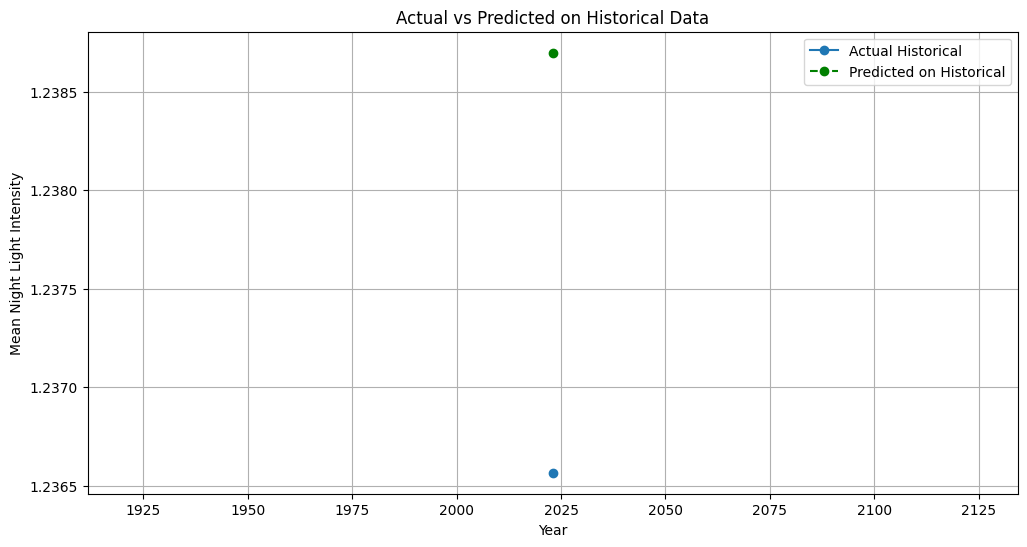

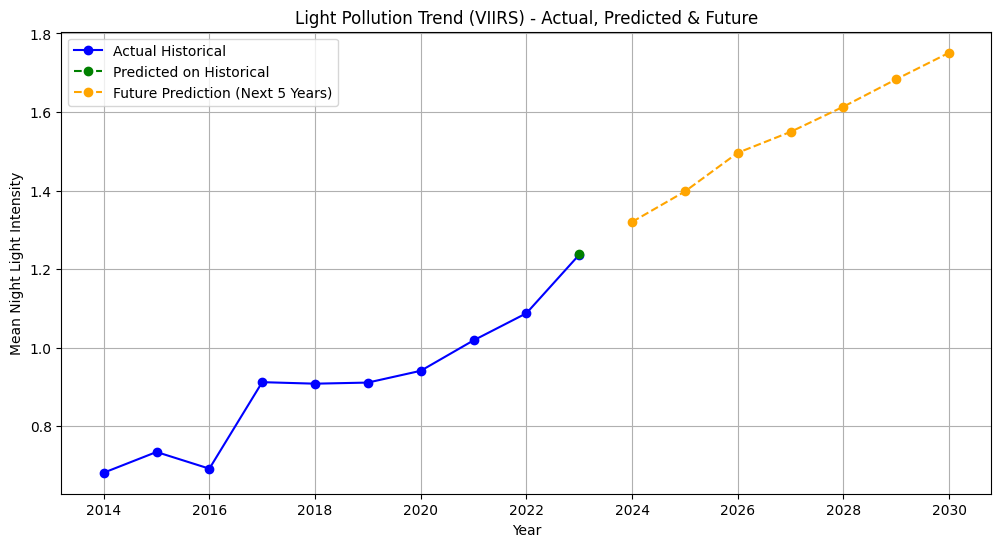

In [10]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import glob
!pip install rasterio
import rasterio
from sklearn.metrics import mean_squared_error, mean_absolute_error





# ---------- 1. Load VIIRS Data ----------
folder_path = 'Orion_India_Data/'
file_paths = sorted(glob.glob(folder_path + '/*.tif'))

years = []
mean_brightness = []

for path in file_paths:
    year = int(path.split('_')[-1].split('.')[0])
    years.append(year)
    with rasterio.open(path) as src:
        data = src.read(1)
        mean_brightness.append(np.nanmean(data))

# ---------- 2. Preprocessing ----------
data = np.array(mean_brightness).reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Sequence creation
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 9
X, y = create_sequences(scaled_data, seq_length)

# ---------- 3. Model ----------
model = Sequential()
model.add(Input(shape=(seq_length, 1)))
model.add(LSTM(256, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(1, kernel_regularizer=l2(0.001)))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

es = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

history = model.fit(X, y, epochs=300, batch_size=2, callbacks=[es], verbose=1)

# ---------- 4. Predict on Historical Data ----------
y_pred_scaled = model.predict(X, verbose=0)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y)

# ---------- 5. Evaluate Model ----------
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# ---------- 6. Future Prediction ----------
future_steps = 7
future_years = [years[-1] + i for i in range(1, future_steps + 1)]
last_seq = scaled_data[-seq_length:].reshape(1, seq_length, 1)

future_preds_scaled = []
for _ in range(future_steps):
    pred = model.predict(last_seq, verbose=0)
    future_preds_scaled.append(pred[0, 0])
    pred_reshaped = np.reshape(pred, (1, 1, 1))
    last_seq = np.append(last_seq[:, 1:, :], pred_reshaped, axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

# ---------- 7. Plot Historical Actual vs Predicted ----------
plt.figure(figsize=(12, 6))
plt.plot(years[seq_length:], y_actual.flatten(), 'o-', label='Actual Historical')
plt.plot(years[seq_length:], y_pred.flatten(), 'o--', label='Predicted on Historical', color='green')
plt.xlabel('Year')
plt.ylabel('Mean Night Light Intensity')
plt.title('Actual vs Predicted on Historical Data')
plt.legend()
plt.grid(True)
plt.show()

# ---------- 8. Plot Full Trend (Historical + Future) ----------
all_years = years + future_years
all_brightness = mean_brightness + list(future_preds.flatten())

plt.figure(figsize=(12, 6))
plt.plot(years, mean_brightness, 'o-', label='Actual Historical', color='blue')
plt.plot(years[seq_length:], y_pred.flatten(), 'o--', label='Predicted on Historical', color='green')
plt.plot(future_years, future_preds.flatten(), 'o--', label='Future Prediction (Next 5 Years)', color='orange')
plt.xlabel('Year')
plt.ylabel('Mean Night Light Intensity')
plt.title('Light Pollution Trend (VIIRS) - Actual, Predicted & Future')
plt.legend()
plt.grid(True)
plt.show()




In [11]:
!pip install scikit-learn

import os
import pandas as pd
import numpy as np
import json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib



# Folder where CSV files are stored
viirs_folder = "VIIRS/"

# List all CSV files
csv_files = sorted([f for f in os.listdir(viirs_folder) if f.endswith(".csv")])

# Initialize list for all data
all_data = []

for file in csv_files:
    try:
        # Extract the year safely
        year_str = file.split("_")[-1].replace(".csv", "")
        year = int(year_str)  # Convert to integer (this will fail if it's not a valid year)

        file_path = os.path.join(viirs_folder, file)
        df = pd.read_csv(file_path)

        # Extract Latitude & Longitude from `.geo` column
        def extract_coords(geo_str):
            try:
                geo_json = json.loads(geo_str.replace("'", "\""))  # Convert string to JSON
                lon, lat = geo_json["coordinates"]
                return lat, lon  # Return as tuple
            except:
                return None, None  # Return NaN if extraction fails

        df[['latitude', 'longitude']] = df['.geo'].apply(lambda x: pd.Series(extract_coords(x)))

        # Drop unnecessary columns
        df = df[['latitude', 'longitude', 'avg_rad']]
        df.loc[:,'year'] = year  # Assign year column

        all_data.append(df)
    except ValueError:
        print(f"Skipping file: {file} (Invalid year format)")

# Concatenate all data
df = pd.concat(all_data, ignore_index=True)
print(f"✅ Loaded dataset with {df.shape[0]} rows.")


print(df.head())



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Loaded dataset with 50000 rows.
    latitude  longitude   avg_rad  year
0   9.775916  77.630161  0.111855  2014
1  22.204108  88.634523  0.194905  2014
2  16.922014  94.298401  0.041613  2014
3   8.886584  78.128726  0.490146  2014
4  32.314647  73.214941  0.337918  2014


In [ ]:
# Feature Selection
X = df[['latitude', 'longitude', 'year']]
y = df['avg_rad']  # Light pollution values

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model (optimized for fast training)
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    n_jobs=-1
)

# Train the model
print("Training model...")
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"📉 Mean Absolute Error: {mae}")

# Save the model
model_path = "xgboost_model.pkl"
joblib.dump(model, model_path)
print(f"✅ Model saved at: {model_path}")


In [12]:
import pandas as pd
import joblib
import numpy as np


# 🔹 Load the trained XGBoost model
model = joblib.load('xgboost_model.pkl')  # Change path if needed

# 🔹 Load the preprocessed dataset used for training
training_data = df  # Update with actual path

# 🔹 Select relevant features (exclude target variable)
features = training_data.drop(columns=['avg_rad'])

# 🔹 Prepare for future predictions (2025-2029)
future_years = [2024,2025, 2026, 2027, 2028]
future_predictions = []

for year in future_years:
    temp_features = features.copy()
    temp_features['year'] = year  # Set year to future year

    # Predict light pollution
    predicted_values = model.predict(temp_features)  # Drop lat/lon before prediction

    # Store predictions
    temp_df = temp_features[['latitude', 'longitude']].copy()
    temp_df['year'] = year
    temp_df['predicted_light_pollution'] = predicted_values
    future_predictions.append(temp_df)

# 🔹 Combine all predictions and save to CSV
final_df = pd.concat(future_predictions)
final_df.to_csv('future_predictions.csv', index=False)

print("✅ Future predictions saved to 'future_predictions.csv'")


✅ Future predictions saved to 'future_predictions.csv'
